# Laboratorio 6: Árboles de Decisión y Bagging

Integrantes: Pablo Arroyo Martínez (Sección 2) // Natalia Valencia Valenzuela (Sección 2)

## Instrucciones


1. Trabajen en equipos de dos personas. Salvo excepciones, no se corregirá entregas con menos de dos integrantes.

2. Modifiquen este archivo `.ipynb` agregando sus respuestas donde corresponda.

3. Cuando finalicen el laboratorio, **generen un archivo HTML** usando jupyter y súbanlo a U-Cursos. El laboratorio debe ser entregado sólo por 1 integrante. Si se entrega por más de un integrante, se revisará cualquiera de éstos.

In [70]:
import matplotlib.pyplot as plt
import numpy as np
from tp_arbres_source import rand_checkers, plot_2d, frontiere

## Árboles de Decisión

### Definición de problema y notaciones

Estamos trabajando en el problema de clasificación multiclase con $K$ clases. Para recordar las notaciones, puedes consultar el laboratorio sobre $k$-vecinos más cercanos (k-NN). Suponemos que se ha observado un conjunto de entrenamiento de tamaño $n$: $\mathcal{D}_n = {(\mathbf{x}_i , y_i),; i = 1, \dots, n}$ que contiene $n$ observaciones y sus etiquetas. Como recordatorio: $\mathbf{x}_i = (x_1,\dots,x_p)^\top \in \mathcal{X} \subset \mathbb{R}^p$ es una observación. En el caso bidimensional, $p = 2$.

### Generación de datos artificiales
Puedes reutilizar las funciones de generación de datos del laboratorio anterior (k-NN). Para visualizar algunos conjuntos de datos, puedes usar y modificar las funciones plot_2d o plot_2d_simple del archivo tp_arbres_source.py.

### Algoritmo de CART

Recordemos cómo funciona un árbol de decisión. Nota que solo consideramos árboles binarios aquí: un nodo puede tener dos hijos o ninguno si es una hoja.

Toda partición de datos puede representarse como un árbol. Inicialmente, el árbol se limita a un solo nodo, la raíz, que representa todo el espacio $\mathcal{X}$. Recursivamente, en cada paso se elige:

una variable $x_k$ (entre las $p$ posibles),

un umbral $\tau \in \mathbb{R}$

y se divide el espacio de entrada $\mathcal{X}$ en dos subconjuntos representados por dos nodos en el árbol:

$I(j,\tau) = {x = (x_1,\dots,x_p)^\top \in \mathbb{R}^p : x_j < \tau }$

$D(j,\tau) = {x = (x_1,\dots,x_p)^\top \in \mathbb{R}^p : x_j \geq \tau }$

En cada paso, el número de componentes en la partición—y, de forma equivalente, el número de hojas del árbol—aumenta.
Este proceso se repite hasta que se cumple un criterio de parada, que puede ser:

- La profundidad del árbol supera un umbral dado,

- El número de observaciones en un nodo cae por debajo de un umbral,

- El número de hojas supera un límite especificado.

En la siguiente imagen se muestra un ejemplo:
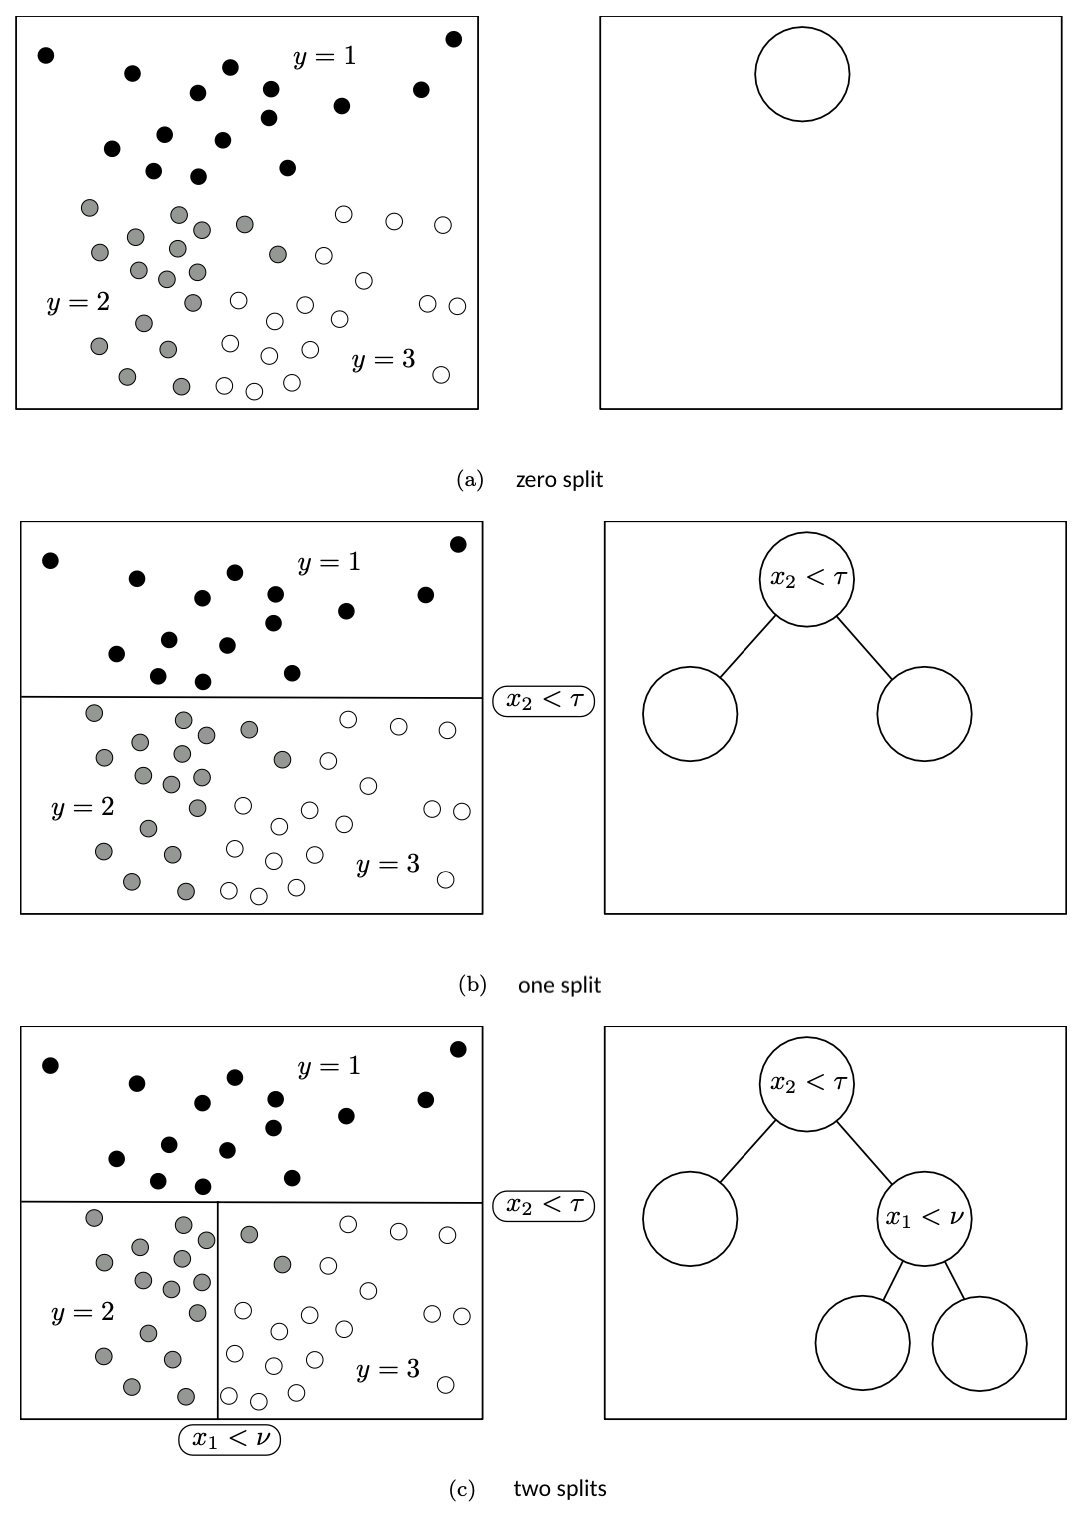

Ahora necesitamos definir una regla para decidir dónde dividir. Esta elección es crucial y no es única. Usamos una función para medir la "impureza", denotada por $H$, asociada a una partición. Buscamos la división (variable/umbral) que produzca la partición más pura según $H$. Matemáticamente, resolvemos:

$$
\arg\min_{j \in [ 1,p ],\; \tau \in \mathbb{R}} \widehat{q}_{j,\tau} H(G(j,\tau)) + (1 - \widehat{q}_{j,\tau}) H(D(j,\tau))
$$

donde:

$$
\widehat{q}_{j,\tau} =
\frac{|\{i \in [ 1,n ] : x_i \in I(j,\tau)\}|}
{|\{i' \in [ 1,n ] : x_{i'} \in I(j,\tau) \cup D(j,\tau)\}|}
$$

es la proporción de observaciones que caen en $I(j,\tau)$. Aquí, $|\cdot|$ denota la cardinalidad del conjunto.

Para cualquier conjunto $R \subset \mathbb{R}^p$ y etiqueta $k$, sea $\widehat{p}_k(R)$ la proporción de observaciones con etiqueta $k$ (indexadas de 1 a $K$):

$$
\widehat{p}_k(R) =
\frac{|\{i \in [ 1,n ] : x_i \in R \land y_i = k\}|}
{|\{i \in [ 1,n ] : x_i \in R\}|}
$$

CART considera las siguientes medidas de impureza $H$:

- Gini index: $\sum_{k=1}^K \widehat{p}_k(R)(1 - \widehat{p}_k(R))$
- Entropy: $-\sum_{k=1}^K \widehat{p}_k(R)\log(\widehat{p}_k(R))$

### Preguntas

1. Usa `rand_checkers` para simular una muestra de tamaño $n=456$ con 4 clases (asegúrate de que las clases estén bien balanceadas). Crea una curva que muestre el porcentaje de accuracy de la clasificación en función de la profundidad máxima del árbol (rango 1 a 10). Utiliza entropia como criterio del split y no olvides usar un random_state.

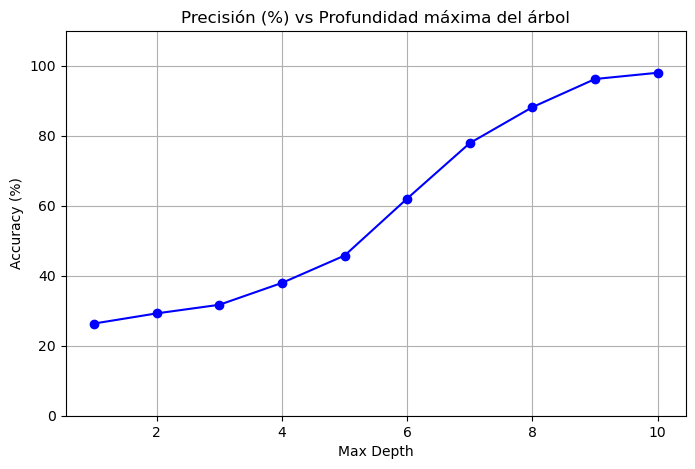

In [81]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

sigma = 0.1
n_samples = 456 // 4

data = rand_checkers(n1=n_samples, n2=n_samples, n3=n_samples, n4=n_samples, sigma=sigma)

X = data[:, :2]
Y = data[:, 2].astype(int)

max_depths = range(1, 11)
accuracy = []
trees = []  #se guardan los arboles para la pregunta 4

for depth in max_depths:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=12345)
    clf.fit(X, Y)
    Y_pred = clf.predict(X)
    acc = accuracy_score(Y, Y_pred)
    accuracy.append(acc * 100)
    trees.append(clf)

plt.figure(figsize=(8, 5))
plt.plot(max_depths, accuracy, marker='o', linestyle='-', color='b')
plt.title('Precisión (%) vs Profundidad máxima del árbol')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.ylim(0, 110)
plt.show()

2. Muestra la clasificación resultante usando la profundidad que minimiza el porcentaje de error con entropía (usa las funciones plot_2d y frontiere del archivo fuente).

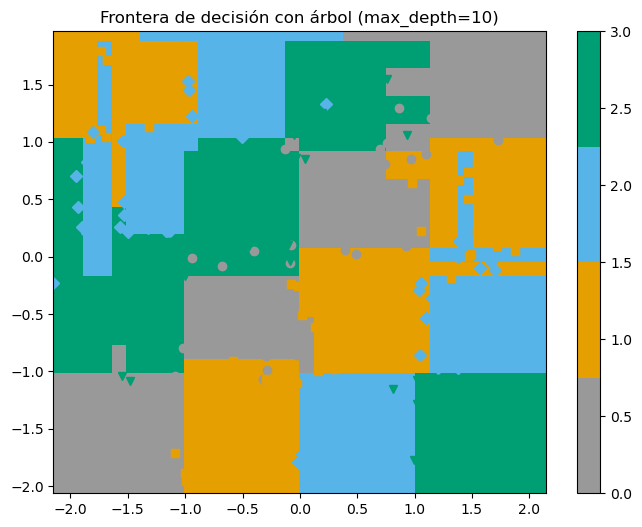

In [82]:
best_depth = 10

clf = DecisionTreeClassifier(criterion='entropy', max_depth=best_depth, random_state=12345)
clf.fit(X, Y)

def predict_func(data):
    return clf.predict(data)

plt.figure(figsize=(8, 6))
frontiere(predict_func, X)
plot_2d(X, Y)
plt.title(f'Frontera de decisión con árbol (max_depth={best_depth})')
plt.show()

3. Vuelve a entrenar un árbol de decisión, pero con una profundidad máxima de 5. Luego genera un gráfico del árbol de decisión de la pregunta anterior. Hint: usar la función `plot_tree` del módulo `tree` de sklearn.

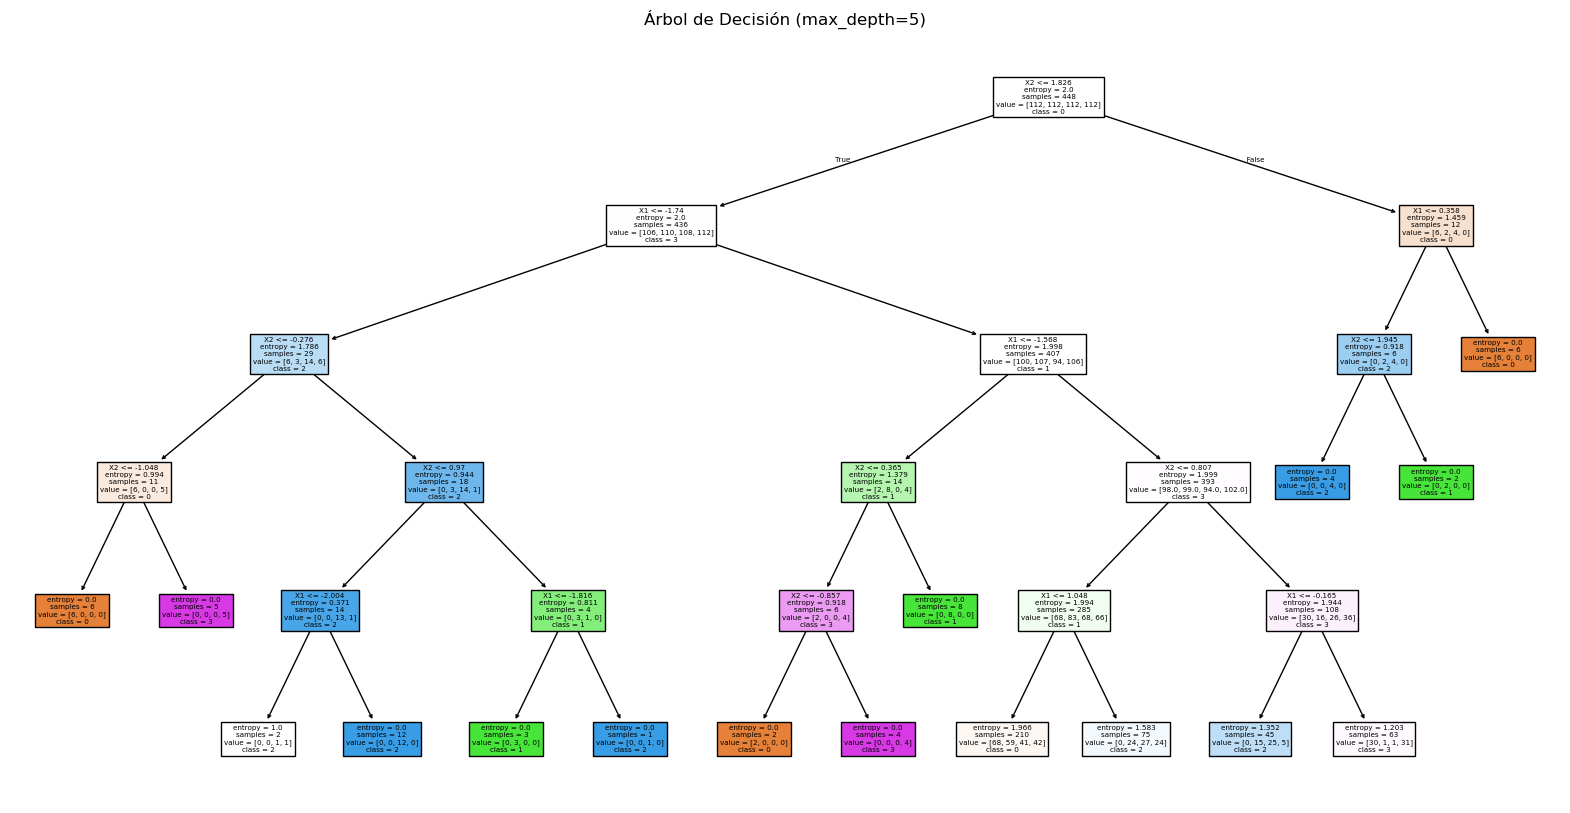

In [83]:
from sklearn.tree import plot_tree

clf = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=12345)
clf.fit(X, Y)

plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=['X1', 'X2'], class_names=[str(i) for i in np.unique(Y)])
plt.title("Árbol de Decisión (max_depth=5)")
plt.show()

4. Genera $n=160$ nuevos puntos de datos con rand_checkers. Para los árboles de decisión obtenidos en la pregunta 1, calcula el accuracy en esta segunda muestra. Comenta diferencias en la accuracy.

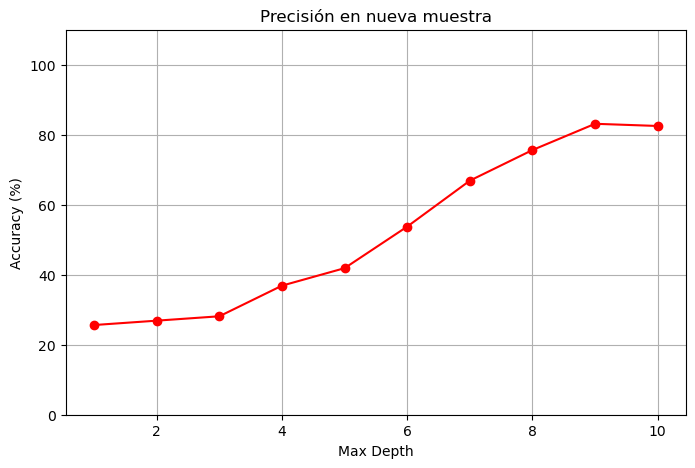

In [84]:
new_n_samples = 160 // 4

data_test = rand_checkers(n1=new_n_samples, n2=new_n_samples, n3=new_n_samples, n4=new_n_samples, sigma=sigma)

X_test = data_test[:, :2]
Y_test = data_test[:, 2].astype(int)

new_accuracy = []
for clf in trees:
    Y_pred_test = clf.predict(X_test)
    acc_test = accuracy_score(Y_test, Y_pred_test)
    new_accuracy.append(acc_test * 100)

plt.figure(figsize=(8, 5))
plt.plot(max_depths, new_accuracy, marker='o', linestyle='-', color='r')
plt.title('Precisión en nueva muestra')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 110)
plt.grid(True)
plt.show()

>**Respuesta:** Empieza bastante parecido al gráfico de precisión de la pregunta uno, pero a partir de una profundidad de 9, la precisión empieza a decaer con estos nuevos datos (overfitting debido a un valor grande de profundidad).

5. Repite el experimento de la pregunta 4 para el conjunto de datos zipcode. Este conjunto está disponible en sklearn.datasets. Puedes cargarlo usando la función load_digits (o ver más en [http://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html](http://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html)):

```python
digits = datasets.load_digits()
 ```

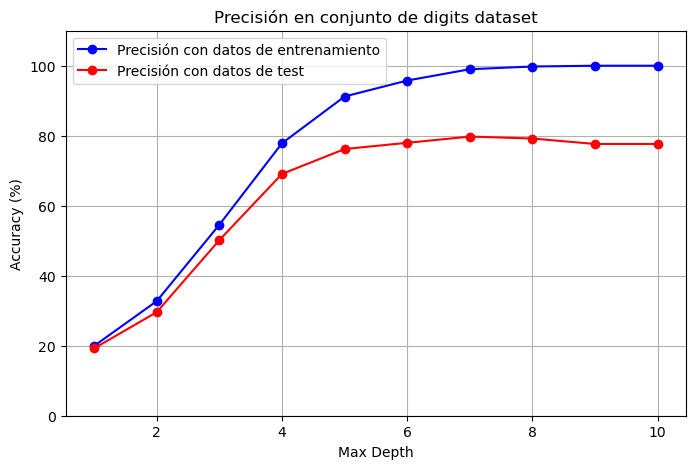

In [75]:
from sklearn import datasets

digits = datasets.load_digits()

n_samples = len(digits.data)
X = digits.data[:n_samples // 2]
Y = digits.target[:n_samples // 2]
X_test = digits.data[n_samples // 2:]
Y_test = digits.target[n_samples // 2:]

max_depths = range(1, 11)
accuracy = []
accuracy_test = []

for depth in max_depths:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=12345)
    clf.fit(X, Y)

    Y_pred = clf.predict(X)
    acc = accuracy_score(Y, Y_pred)
    accuracy.append(acc * 100)

    Y_pred_test = clf.predict(X_test)
    acc_test = accuracy_score(Y_test, Y_pred_test)
    accuracy_test.append(acc_test * 100)

plt.figure(figsize=(8, 5))
plt.plot(max_depths, accuracy, marker='o', linestyle='-', color='b', label='Precisión con datos de entrenamiento')
plt.plot(max_depths, accuracy_test, marker='o', linestyle='-', color='r', label='Precisión con datos de test')
plt.title('Precisión en conjunto de digits dataset')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 110)
plt.grid(True)
plt.legend()
plt.show()


#### Métodos de selección de parámetros - Selección de modelos

En la práctica, rara vez se dispone de un conjunto de prueba (preferimos incluir la mayor cantidad de datos en el conjunto de entrenamiento, pero en la parte anterior usamos solo la mitad). Para seleccionar un modelo o parámetro utilizando la mayor cantidad posible de ejemplos de entrenamiento, normalmente se usa la validación cruzada. Para cada parámetro, se obtiene una estimación del error empírico de la siguiente manera:

Dividir el conjunto de entrenamiento en $N$ subconjuntos de tamaño $n/N$

Para cada subconjunto, medir el error del clasificador (con el conjunto de parámetros fijado) entrenado con los otros $N-1$ subconjuntos

El error estimado es el promedio de los errores de todos los clasificadores entrenados

Esto se puede repetir sobre una malla de parámetros para obtener una estimación de error por parámetro, y luego elegir el parámetro que minimiza dicha estimación.

Para más detalles sobre las funcionalidades de validación cruzada en scikit-learn, consulta http://scikit-learn.org/stable/modules/cross_validation.html.

6. Usa la función `sklearn.model_selection.cross_val_score` con 5 folds, y pruébala en el conjunto de datos zipcode variando la profundidad del árbol. Con esta función, determina la mejor profundidad máxima (puedes aumentar el rango) y la precisión promedio obtenida con ella.

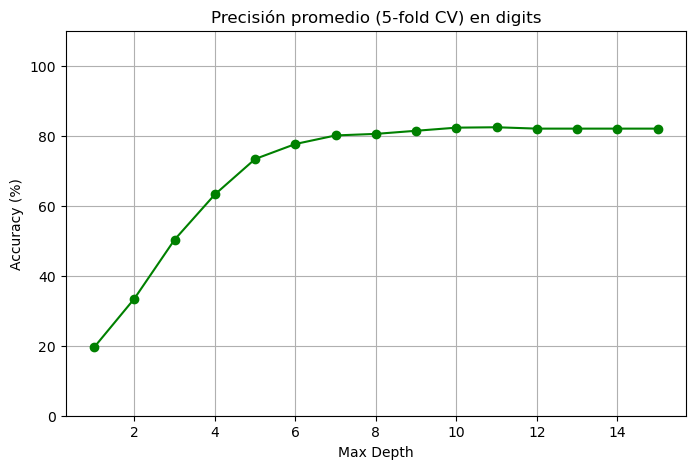

Mejor profundidad: 11
Precisión promedio (5-fold CV): 82.42%


In [76]:
from sklearn.model_selection import cross_val_score

digits = datasets.load_digits()
X = digits.data
Y = digits.target

dmax = 15 # Rango máximo a probar para profundidad

mean_accuracy = []

for depth in range(1, dmax + 1):
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=12345)
    scores = cross_val_score(clf, X, Y, cv=5)
    mean_acc = np.mean(scores) * 100
    mean_accuracy.append(mean_acc)

plt.figure(figsize=(8, 5))
plt.plot(range(1, dmax + 1), mean_accuracy, marker='o', linestyle='-', color='g')
plt.title('Precisión promedio (5-fold CV) en digits')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 110)
plt.grid(True)
plt.show()

best_depth = np.argmax(mean_accuracy) + 1
best_accuracy = mean_accuracy[best_depth - 1]

print(f"Mejor profundidad: {best_depth}")
print(f"Precisión promedio (5-fold CV): {best_accuracy:.2f}%")

## Bagging de Árboles de decisión: Random Forests

Bagging (abreviación de "Bootstrap Aggregation"; Breiman et al. 96) es un método clásico para ponderar modelos. Consiste simplemente en promediar las predicciones con $w_l = 1/L$. Para generar datos de entrenamiento aleatorios, utiliza muestreo bootstrap. Una muestra bootstrap es una muestra de $n$ puntos de entrenamiento extraídos de $\mathcal{D}$ mediante muestreo aleatorio con reemplazo.

### Funcionamiento

Consideremos el problema estándar de aprendizaje supervisado. Dado un conjunto de entrenamiento $\mathcal{D} = {(X_1, Y_1), \dots, (X_n, Y_n)}$ generado por una función desconocida $f$, donde $Y = f(X)$, un algoritmo de aprendizaje estima $\hat{f}_\mathcal{D}$, que es el modelo estimado. Si los valores $Y_i$ están en ${1, \dots, K}$, tenemos un problema de clasificación con $K$ clases; si los valores $Y_i$ están en $\mathbb{R}$, es un problema de regresión.

Una agregación de modelos (clasificadores/estimadores) se obtiene mediante una combinación (lineal) de las predicciones individuales de cada modelo. En regresión, el modelo agregado $\hat{F}\mathcal{D}^L$ se obtiene a partir de $L$ clasificadores/estimadores $\hat{f}\mathcal{D}^l,; l = 1,\dots,L$ de la siguiente forma:

$$ \hat{F}_\mathcal{D}^L(X) = \sum_{l=1}^{L} w_l \hat{f}_\mathcal{D}^l(X)$$

donde $w_l \geq 0$ son los pesos.

En clasificación, la agregación puede hacerse mediante votación (devolviendo la clase predicha por la mayoría de los estimadores), promediando las probabilidades de clase o promediando el margen.
Si un clasificador binario $\hat{f}\mathcal{D}^l$ predice $X$ usando el signo de $\hat{f}\mathcal{D}^l(X)$, el modelo agregado usa el signo de $\sum_{l=1}^{L} w_l \hat{f}_\mathcal{D}^l(X)$.

Una condición necesaria y suficiente para que el modelo agregado sea más preciso que cada modelo individual es que cada uno tenga un rendimiento mejor que el azar y que hagan predicciones distintas cuando se entrenan con diferentes datos.
La idea central de la agregación es que promediar las predicciones de múltiples modelos independientes reduce la varianza y, por lo tanto, el error de predicción.

Random Forest es un modelo basado en Bagging.

### Regresor

7. Escriba un script que implemente el método `Bagging` utilizando árboles de decisión de profundidad 1 (también llamados *stumps*) y, posteriormente, árboles más profundos. Utilice el código a continuación como punto de partida. Puede usar  `np.random.randint` para generar muestras de bootstrap.

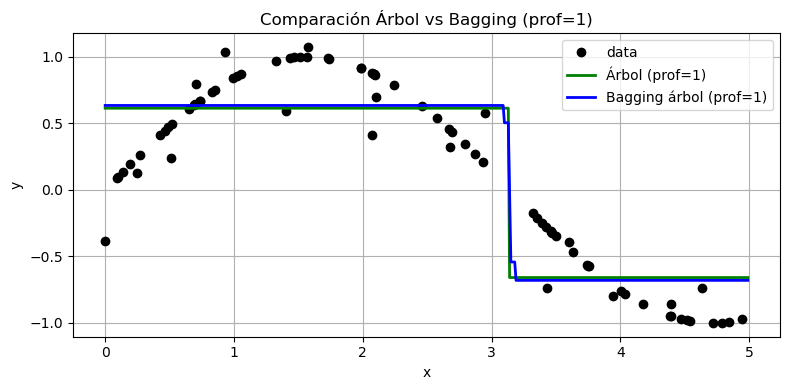

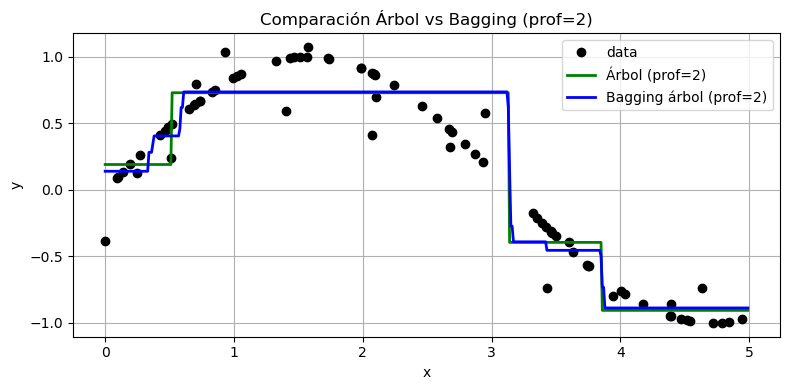

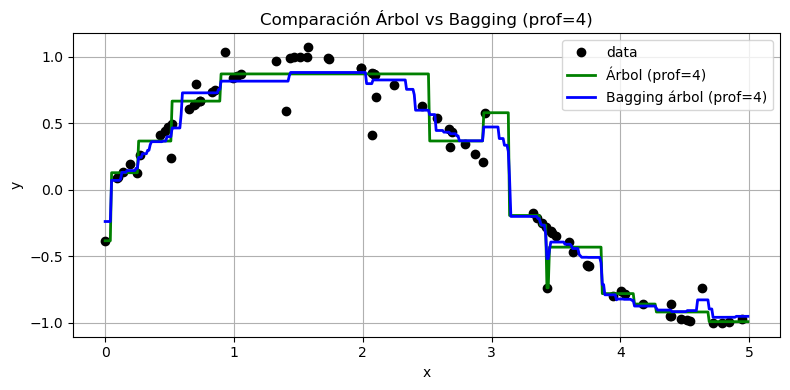

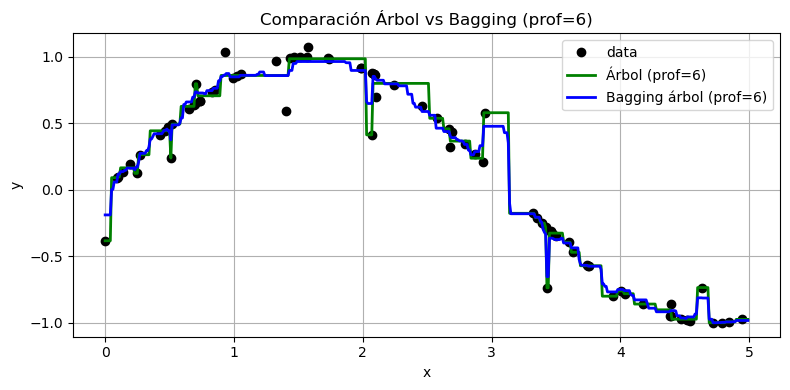

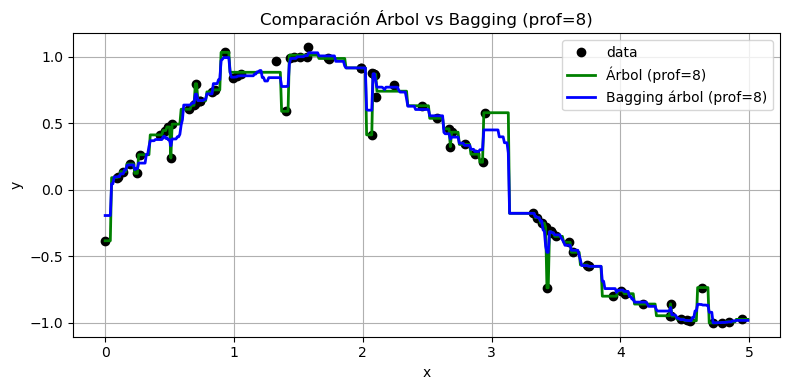

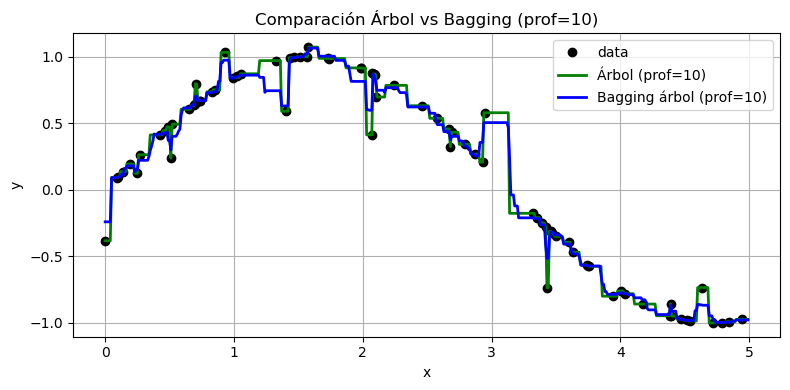

In [77]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

# Crear un dataset random: funcion seno con cierto ruido
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0) # matriz ordenada de 80 numeros random entre 0 y 5
y = np.sin(X).ravel()
noise_level = 1
y[::5] += (0.5 - rng.rand(16)) * noise_level # introduce ruido cada 5 datos

n_estimators = 10 # L

list_depths = [1, 2, 4, 6, 8, 10]
trees = []
bagging_trees = []


for depth in list_depths:
    tree = DecisionTreeRegressor(max_depth=depth)
    tree.fit(X, y)
    trees.append(tree)
    bagging_tree = BaggingRegressor(
        estimator=DecisionTreeRegressor(max_depth=depth),
        n_estimators=n_estimators,
        random_state=rng,
    )
    bagging_tree.fit(X, y)
    bagging_trees.append(bagging_tree)

X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
pred_tree = [tree.predict(X_test) for tree in trees]
pred_bagging = [btree.predict(X_test) for btree in bagging_trees]

for i, depth in enumerate(list_depths):
    plt.figure(figsize=(8, 4))
    plt.plot(X, y, 'o', c="k", label="data")
    plt.plot(X_test, pred_tree[i], color='g', label=f'Árbol (prof={depth})', linewidth=2)
    plt.plot(X_test, pred_bagging[i], color='b', label=f'Bagging árbol (prof={depth})', linewidth=2)
    plt.title(f'Comparación Árbol vs Bagging (prof={depth})')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

* Observe el efecto de $L$ y la profundidad del árbol (`max_depth`).
* ¿Cómo puede determinar que los estimadores basados en árboles están sesgados y que el bagging reduce su varianza?
* Experimentando con el nivel de ruido, resalte el overfitting. ¿Cómo se ve en el gráfico?

> **Respuesta:** Al ver los gráficos obtenidos, se nota que al usar bagging, la curva es menos sesgada al acercarse menos a los datos de ruido, mientras que usando solo el árbol, la curva se desestabiliza acercándose mucho a aquellos datos lo cual es malo para un modelo haciendo que tenga menos capacidad de generalización.
Un mayor nivel de ruido hace que las curvas se desestabilicen aún más, aumentando así el overfitting, aunque aquella desestabilización ocurre en menor medida usando bagging.

### Clasificador

Ahora, probemos con clasificadores.

8. Observa la decisión de frontera entre un árbol de decisión y un random forest. ¿Qué se puede decir sobre la generalización de la predicción del DT único y del conjunto? Usa la clase `BaggingClassifier`.

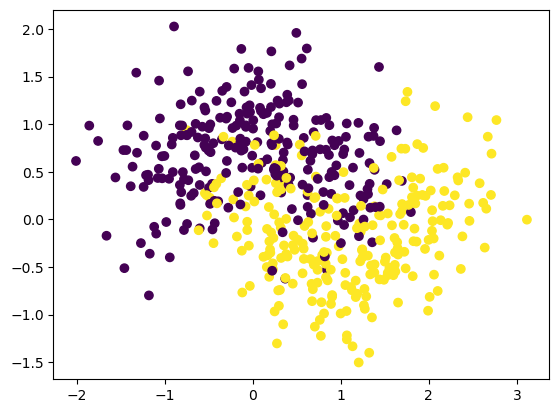

In [78]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.4, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y);

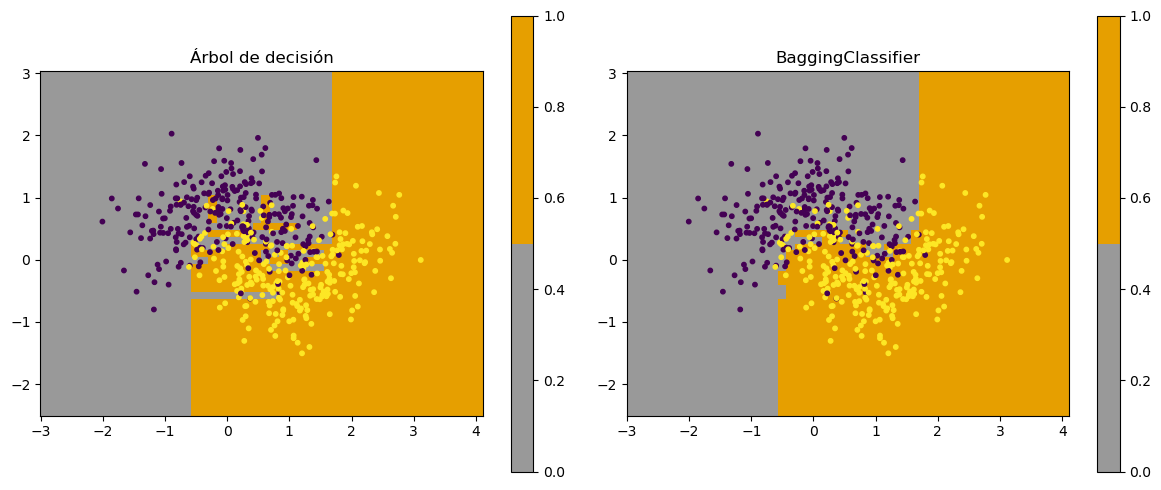

In [79]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    n_jobs=-1,
    random_state=42
)
bag_clf.fit(X_train, y_train)

dt_clf = DecisionTreeClassifier(random_state=12345)
dt_clf.fit(X_train, y_train)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
frontiere(lambda x: dt_clf.predict(x), X)
plt.scatter(X[:, 0], X[:, 1], c=y, s=10)
plt.title("Árbol de decisión")

plt.subplot(1, 2, 2)
frontiere(lambda x: bag_clf.predict(x), X)
plt.scatter(X[:, 0], X[:, 1], c=y, s=10)
plt.title("BaggingClassifier")

plt.tight_layout()
plt.show()

>**Respuesta:** Frontera más definida/clara usando bagging, lo que indica una mayor capacidad de generalización.

9. Compare los scores de 5-fold cross-validation de random forest y arboles de decisión (utilizando `DecisionTreeClassifier`). Varíe el parámetro `max_depth` de 1 a 30. Note cómo random forest ayuda a reducir el overfitting incluso con árboles profundos.

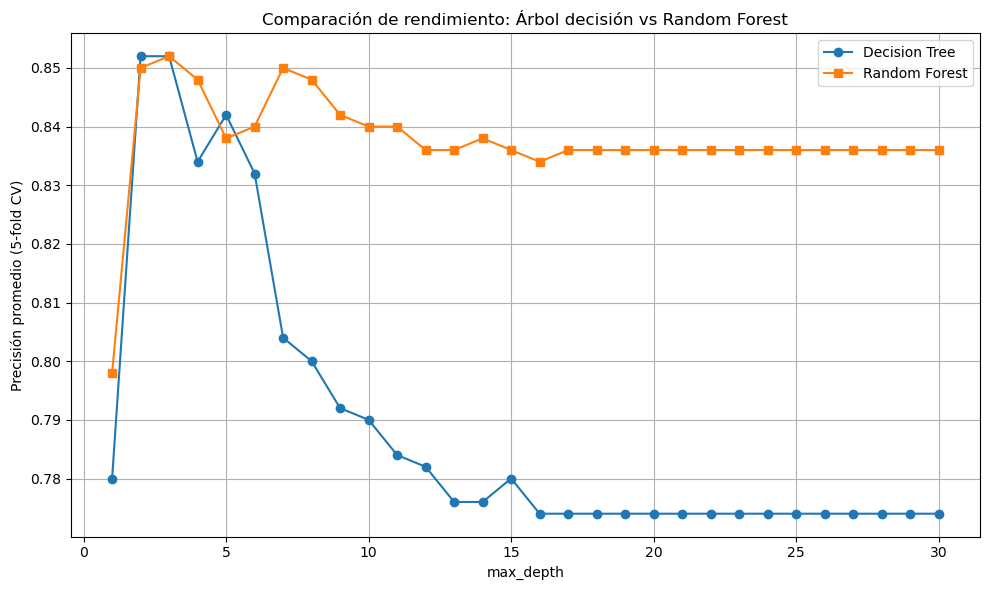

In [80]:
from sklearn.ensemble import RandomForestClassifier

dt_scores = []
rf_scores = []

depth_range = range(1, 31)

for depth in depth_range:

    dt_clf = DecisionTreeClassifier(random_state=42, max_depth=depth)
    rf_clf = RandomForestClassifier(random_state=42, max_depth=depth)

    dt_cv_score = cross_val_score(dt_clf, X, y, cv=5, scoring='accuracy').mean()
    rf_cv_score = cross_val_score(rf_clf, X, y, cv=5, scoring='accuracy').mean()

    dt_scores.append(dt_cv_score)
    rf_scores.append(rf_cv_score)

plt.figure(figsize=(10, 6))
plt.plot(depth_range, dt_scores, label="Decision Tree", marker='o')
plt.plot(depth_range, rf_scores, label="Random Forest", marker='s')
plt.xlabel("max_depth")
plt.ylabel("Precisión promedio (5-fold CV)")
plt.title("Comparación de rendimiento: Árbol decisión vs Random Forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()